In [36]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../src')

from utils.paths import gaul_path
from gee_helpers import authenticate_ee, request_gee_image, get_utm_crs

import geopandas as gpd
import ee
import eemont
import xarray as xr
import rioxarray as rxr
import xee
import geemap


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
authenticate_ee()

In [3]:
gaul_gdf = gpd.read_file(gaul_path)
gaul_gdf

,iso3_code,map_code,gaul0_code,gaul0_name,gaul1_code,gaul1_name,gaul2_code,gaul2_name,continent,disp_en,geometry
0,TZA,TZA,166,United Republic of Tanzania,1679,Arusha,106380,Arumeru,Africa,"Arumeru, Arusha, United Republic of Tanzania","POLYGON ((36.71467 -3.56221, 36.71439 -3.56391..."
1,TZA,TZA,166,United Republic of Tanzania,1679,Arusha,106381,Arusha,Africa,"Arusha, Arusha, United Republic of Tanzania","POLYGON ((36.71475 -3.5607, 36.70735 -3.56379,..."
2,TZA,TZA,166,United Republic of Tanzania,1679,Arusha,106382,Karatu,Africa,"Karatu, Arusha, United Republic of Tanzania","POLYGON ((35.83594 -3.36915, 35.83334 -3.37666..."
3,TZA,TZA,166,United Republic of Tanzania,1679,Arusha,106383,Longido,Africa,"Longido, Arusha, United Republic of Tanzania","POLYGON ((36.17068 -2.20099, 36.1709 -2.20112,..."
4,TZA,TZA,166,United Republic of Tanzania,1679,Arusha,106384,Monduli,Africa,"Monduli, Arusha, United Republic of Tanzania","POLYGON ((36.60573 -3.10696, 36.6485 -3.14393,..."
...,...,...,...,...,...,...,...,...,...,...,...
45519,SLV,SLV,191,El Salvador,2025,Sonsonate,145717,Sonsonate Oeste,America,"Sonsonate Oeste, Sonsonate, El Salvador","POLYGON ((-89.81993 13.66957, -89.81818 13.668..."
45520,SLV,SLV,191,El Salvador,2026,Usulután,145718,Usulután Este,America,"Usulután Este, Usulután, El Salvador","MULTIPOLYGON (((-88.46236 13.20625, -88.46236 ..."
45521,SLV,SLV,191,El Salvador,2026,Usulután,145719,Usulután Norte,America,"Usulután Norte, Usulután, El Salvador","POLYGON ((-88.50626 13.45661, -88.50713 13.455..."
45522,SLV,SLV,191,El Salvador,2026,Usulután,145720,Usulután Oeste,America,"Usulután Oeste, Usulután, El Salvador","MULTIPOLYGON (((-88.46264 13.17875, -88.46236 ..."


<Axes: >

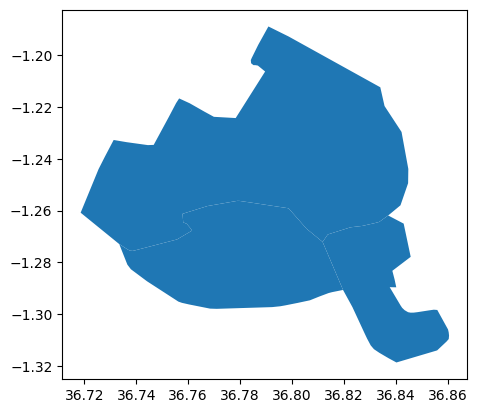

In [4]:
nairobi_gdf = gaul_gdf[gaul_gdf['gaul1_name'] == 'Nairobi']
roi_gdf = nairobi_gdf[nairobi_gdf['gaul2_name'].isin(["Starehe", "Westlands", "Kilimani"])]
roi_gdf.plot()

In [17]:
bbox = roi_gdf.total_bounds.tolist()  # [minx, miny, maxx, maxy]
utm_crs = get_utm_crs(bbox)
utm_crs

'EPSG:32737'

In [50]:

spectral_indexes = ['NDVI', 'NDWI', 'NDBI']
imagery_ee_path = 'COPERNICUS/S2_HARMONIZED'
cloud_coverage = 10
start_date = '2017-01-01'
end_date = '2017-12-31'

In [51]:
roi_ic = request_gee_image(imagery_ee_path, start_date, end_date, bbox)
roi_ic

In [52]:
imagery_ic = (roi_ic \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_coverage)) \
    .spectralIndices(spectral_indexes).mean() \
    .select(spectral_indexes))
imagery_ic

In [53]:
bbox_fc = ee.Geometry.Rectangle([bbox[:2], bbox[2:]])

ic_ds = xr.open_dataset(imagery_ic, engine="ee", geometry=bbox_fc, scale=10, crs=utm_crs)
ic_ds = ic_ds.ffill(dim='time').bfill(dim='time').isel(time=0).drop_vars('time')
ic_ds = ic_ds.rename({'Y': 'y', 'X': 'x'}).rio.set_spatial_dims(x_dim='x', y_dim='y')
ic_ds

<xarray.Dataset> Size: 27MB
Dimensions:  (x: 1580, y: 1434)
Coordinates:
  * x        (x) float64 13kB 2.461e+05 2.461e+05 ... 2.619e+05 2.619e+05
  * y        (y) float64 11kB 9.854e+06 9.854e+06 ... 9.868e+06 9.868e+06
Data variables:
    NDVI     (x, y) float32 9MB 0.1906 0.1822 0.149 ... 0.2983 0.3365 0.4185
    NDWI     (x, y) float32 9MB -0.2394 -0.2275 -0.2033 ... -0.3403 -0.3999
    NDBI     (x, y) float32 9MB 0.0216 0.01518 0.02287 ... -0.04956 -0.08848
Attributes:
    crs:      EPSG:32737

In [54]:
ic_da = ic_ds.to_dataarray()
ic_da

<xarray.DataArray (variable: 3, x: 1580, y: 1434)> Size: 27MB
array([[[ 0.19062121,  0.1822054 ,  0.14898449, ...,  0.4337736 ,
          0.49373522,  0.48297676],
        [ 0.3027531 ,  0.29079473,  0.26124322, ...,  0.46576548,
          0.4381937 ,  0.41795594],
        [ 0.27165034,  0.27892372,  0.27820322, ...,  0.5034668 ,
          0.44393075,  0.42631122],
        ...,
        [ 0.1004789 ,  0.08169525,  0.09634528, ...,  0.43249395,
          0.45657375,  0.50095963],
        [ 0.01772908,  0.04227924,  0.07386485, ...,  0.37916598,
          0.41079387,  0.4552307 ],
        [-0.033083  ,  0.01863986,  0.07448107, ...,  0.29833075,
          0.33645523,  0.41845408]],

       [[-0.23937578, -0.22745968, -0.20325571, ..., -0.42898625,
         -0.47346276, -0.46846518],
        [-0.311516  , -0.30507115, -0.2837611 , ..., -0.4484632 ,
         -0.43272126, -0.4334056 ],
        [-0.30405024, -0.30609062, -0.3069093 , ..., -0.45952803,
         -0.43106675, -0.43634686],
...
        [-0.10627358, -0.09729196, -0.12289219, ..., -0.41303694,
         -0.42652327, -0.46398193],
        [-0.04179097, -0.05976214, -0.10597043, ..., -0.38314736,
         -0.40572223, -0.4300744 ],
        [ 0.02808675, -0.03220613, -0.10993401, ..., -0.30927312,
         -0.34028956, -0.3999227 ]],

       [[ 0.02159795,  0.01517724,  0.02286956, ..., -0.05389002,
         -0.07402161, -0.04930869],
        [ 0.07482252,  0.06080508,  0.07816955, ..., -0.03640611,
         -0.06793918, -0.05545514],
        [ 0.09268951,  0.07113412,  0.06740136, ..., -0.02451273,
         -0.04666169, -0.05824371],
        ...,
        [ 0.15602063,  0.12130046,  0.13781193, ..., -0.08253174,
         -0.05939485, -0.12889941],
        [ 0.22105817,  0.1810926 ,  0.16167445, ..., -0.0820141 ,
         -0.07883899, -0.13606553],
        [ 0.19151063,  0.199485  ,  0.1681987 , ..., -0.0347006 ,
         -0.04956178, -0.0884773 ]]], shape=(3, 1580, 1434), dtype=float32)
Coordinates:
  * variable  (variable) object 24B 'NDVI' 'NDWI' 'NDBI'
  * x         (x) float64 13kB 2.461e+05 2.461e+05 ... 2.619e+05 2.619e+05
  * y         (y) float64 11kB 9.854e+06 9.854e+06 ... 9.868e+06 9.868e+06
Attributes:
    crs:      EPSG:32737

In [55]:
ic_da.transpose('variable', 'y', 'x').rio.to_raster('../data/output/spectral_nairobi_2017.tif')

In [46]:
ic_da.dims

('variable', 'x', 'y')

In [13]:
center = [(bbox[1] + bbox[3]) / 2, (bbox[0] + bbox[2]) / 2]
m = geemap.Map(center=center, zoom=12)
m.addLayer(imagery_ic.select('NDVI'), {'min': -1, 'max': 1, 'palette': ['red', 'green']}, 'NDVI')
m.addLayer(geemap.gdf_to_ee(roi_gdf), {}, 'ROI')
m

Map(center=[-1.2537898169464654, 36.78953704839614], controls=(WidgetControl(options=['position', 'transparent…